# Predict last emotion of a dialogue from MELD dataset

In [1]:
import sklearn.metrics

# Set Wandb
import wandb

entity = 'IFT6759-ADV_PROJECT'
project = 'cnn-emotion-prediction'
secret_api_key = 'e3d9da3d2519364013b968011af022ee0bda0091' # 'your_api_key_here'

wandb.login(key=secret_api_key)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\allar\_netrc
wandb: Currently logged in as: toma-allary (toma-allary-universit-de-montr-al) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

### If features were not already processed through WaveLM & RoBERTa

In [7]:
import numpy as np
import pandas as pd
import os
from src.conversation_processing import ConversationProcessor_CNN
import torch
import pickle

# Limit to 50% of the total available memory on the GPU
torch.cuda.set_per_process_memory_fraction(0.95, device=0)

project_dir                 = os.getcwd()
MELD_folder                 = "train"
audio_data_folder           = "train_splits"
text_data_csv_filename      = "train_sent_emo.csv"
combined_audio_data_folder  = "train_combined"
combined_csv_filename       = "MELD_combined_v2.csv"
embeddings_plk_filename     = "final_tensor_conversation_v2"

myProcessor = ConversationProcessor_CNN(
    project_dir=project_dir,
    MELD_folder=MELD_folder,
    audio_data_folder=audio_data_folder,
    text_data_csv_filename=text_data_csv_filename,
    combined_audio_data_folder=combined_audio_data_folder,
    combined_csv_filename=combined_csv_filename,
    embeddings_plk_filename=embeddings_plk_filename)

print(myProcessor.BASE_DIR)

# Check if merged audio exist
if not os.listdir(myProcessor.COMBINED_DIR):
    print("Combined audio is empty. Creating combined audio.")
    # myProcessor.CombineAudio()
else:
    print("Combined audio is already present.")

if not os.path.exists(myProcessor.DATA_CSV_FILE):
    print("Combined csv does not exist, creating it..")
    # combined_df = myProcessor.Create_combined_csv()
else:
    combined_df = pd.read_csv(myProcessor.DATA_CSV_FILE)
    print("Combined csv is already present.")

if not os.path.exists(myProcessor.CODE_FILENAME) or not os.path.exists(myProcessor.CODE_LABEL_FILENAME):
    print("Combined features does not exist. Creating features dataset..")
    # myProcessor.Create_features_dataset(combined_df)
else:
    print("Combined features dataset is already present.")

with open(myProcessor.CODE_FILENAME, 'rb') as f:
    train_dataset_tensor = pickle.load(f)

train_dataset_targets = pd.read_csv(myProcessor.CODE_LABEL_FILENAME)

# Optionally confirm it's a tensor
print("dataset Tensor and CSV loaded.")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ConversationProcessor initialized using device: cuda
C:\Users\allar\Documents\UdeM\IFT6759 AdvProject\Projet\IFT-6759-Advanced-ML-Project
Combined audio is already present.
Combined csv is already present.
Combined features dataset is already present.
dataset Tensor and CSV loaded.


In [8]:
print(f"Dataset shape: {train_dataset_tensor.shape}")
train_dataset_targets

Dataset shape: torch.Size([734, 128, 1536])


,Dialogue_ID,Last_Emotion
0,2,joy
1,3,neutral
2,4,neutral
3,5,surprise
4,6,anger
...,...,...
729,995,neutral
730,996,sadness
731,997,anger
732,998,surprise


# (Optional) Merge test and train
*To improve size of data and get validation on hyper-param*

In [ ]:
################ Folders / Files ################
project_dir                 = os.getcwd()
MELD_folder                 = "test"
audio_data_folder           = "dont_care"
text_data_csv_filename      = "dont_care.csv"
combined_audio_data_folder  = "dont_care"
combined_csv_filename       = "dont_care.csv"
embeddings_plk_filename     = "final_tensor_conversation_v2_test"

myProcessor = ConversationProcessor_CNN(
    project_dir=project_dir,
    MELD_folder=MELD_folder,
    audio_data_folder=audio_data_folder,
    text_data_csv_filename=text_data_csv_filename,
    combined_audio_data_folder=combined_audio_data_folder,
    combined_csv_filename=combined_csv_filename,
    embeddings_plk_filename=embeddings_plk_filename)

with open(myProcessor.CODE_FILENAME, 'rb') as f:
    test_dataset_tensor = pickle.load(f)

test_dataset_targets = pd.read_csv(myProcessor.CODE_LABEL_FILENAME)

# Concat train+test
train_dataset_tensor = torch.cat((train_dataset_tensor, test_dataset_tensor), dim=0)
train_dataset_targets = pd.concat([train_dataset_targets, test_dataset_targets], axis=0)

print(f"Merge tensor length: {train_dataset_tensor.shape}")

## Split train set to have validation

In [16]:
import torch
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset

# Ratio for training
ratio_train = 0.85
batch_size = 32
max_batch_size = 2

# Convert string target into encoded classes
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(train_dataset_targets['Last_Emotion'].values)
# Convert labels into tensor
labels = torch.tensor(labels_encoded, dtype=torch.long)

# Merge features & target in a TensorDataset
dataset = TensorDataset(train_dataset_tensor, labels)

# Split the dataset into train and validation
train_size = int(ratio_train * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoader
train_loader = DataLoader(train_data, batch_size=max_batch_size, num_workers=1, pin_memory=False, shuffle=True)
val_loader = DataLoader(val_data, batch_size=max_batch_size, num_workers=1, pin_memory=False)


print(f"Train dataset shape: {len(train_loader.dataset)}")
print(f"Val dataset shape: {len(val_loader.dataset)}")

Train dataset shape: 623
Val dataset shape: 111


## Train ResNet architecture

In [17]:
import optuna
from sklearn.metrics import f1_score
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
use_amp = torch.cuda.is_available()

# Train according to weight of classes
# Classses weights
y_numpy = []
for _, label in train_loader.dataset:
    y_numpy.append(label)
y_numpy = np.array(y_numpy)

classes_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_numpy), y=y_numpy)
classes_weights = torch.tensor(classes_weights, dtype=torch.float32).to(device)

print(f"classes_weights: {classes_weights}")

class Args:
    lr: float = 0.0001
    epochs: int = 100
    optimizer = "adam"
    weight_decay = 0.0001
    dropout = 0.5


def TrainModel(model: torch.nn.Module, args: Args, optuna_trial: optuna.Trial = None):

    optimizer_delay = -(-batch_size // max_batch_size) # round up
    # after optimizer_delay steps, do backward. This emulate bigger batch_size

    criterion = torch.nn.CrossEntropyLoss(weight=classes_weights)
    if use_amp:
        scaler = torch.amp.GradScaler('cuda')

    if args.optimizer == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, weight_decay=args.weight_decay, momentum=0.9)
    elif args.optimizer == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    elif args.optimizer == "adamw":
        optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    else:
        raise ValueError(f"Unknown optimizer {args.optimizer}")

    # Training and validation loop
    best_val_acc = 0
    best_val_f1 = 0
    pruned = False

    last_train_loss = 0
    last_val_acc = 0
    last_train_acc = 0
    for epoch in range(args.epochs):
        # --- Training ---
        model.train()
        total_loss = 0

        batch_it = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            if use_amp:
                with torch.amp.autocast('cuda'):
                    outputs = model(batch_x)
                    loss = criterion(outputs, batch_y)

                scaler.scale(loss).backward()

                if batch_it % optimizer_delay == 0 or batch_it == len(train_loader) - 1:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
            else:
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                if batch_it % optimizer_delay == 0 or batch_it == len(train_loader) - 1:
                    optimizer.step()
                    optimizer.zero_grad()

            total_loss += loss.item()
            batch_it += 1

        train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}")

        # --- Validation ---
        model.eval()
        val_correct = 0
        val_total = 0
        train_correct = 0
        train_total = 0
        # F1:
        all_val_preds = []
        all_val_labels = []
        with torch.no_grad():
            for batch_x, batch_y in train_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)

                outputs = model(batch_x)
                _, predicted = torch.max(outputs, 1)
                train_total += batch_y.size(0)
                train_correct += (predicted == batch_y).sum().item()

            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)

                outputs = model(batch_x)
                _, predicted = torch.max(outputs, 1)
                val_total += batch_y.size(0)
                val_correct += (predicted == batch_y).sum().item()

                # Collect for F1
                all_val_preds.extend(predicted.cpu().numpy())
                all_val_labels.extend(batch_y.cpu().numpy())

        val_accuracy = val_correct / val_total * 100
        train_accuracy = train_correct / train_total * 100
        weighted_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')
        macro_f1 = f1_score(all_val_labels, all_val_preds, average='macro')
        print(f"Weighted F1 score: {weighted_f1:.4f}")
        print(f"Macro F1 score: {macro_f1:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.2f}%")
        print(f"Train Accuracy: {train_accuracy:.2f}%")


        if optuna_trial is not None:
            # Optuna pruning
            optuna_trial.report(val_accuracy, step=epoch)
            # Prune if trial is not promising
            if optuna_trial.should_prune():
                pruned = True
                return train_loss, train_accuracy, val_accuracy, best_val_acc, pruned

        best_val_acc = max(best_val_acc, val_accuracy)
        best_val_f1 = max(best_val_f1, weighted_f1)
        last_train_loss = train_loss
        last_val_acc = val_accuracy
        last_train_acc = train_accuracy

        # Log metrics using the global context
        wandb.log({
            "train_acc": train_accuracy,
            "train_loss": train_loss,
            "val_acc": val_accuracy,
            "weighted_f1": weighted_f1,
            "macro_f1": macro_f1
        })
        wandb.log({
            "val_conf_mat" : wandb.plot.confusion_matrix(
                probs=None,
                y_true=all_val_labels,
                preds=all_val_preds,
                class_names=label_encoder.classes_)
        })

        # Clear cache after each epoch
        torch.cuda.empty_cache()

    return last_train_loss, last_train_acc, last_val_acc, best_val_acc, best_val_f1, pruned

Using device: cuda
classes_weights: tensor([1.1867, 4.4500, 5.5625, 0.8018, 0.3134, 1.7800, 1.3284],
       device='cuda:0')


In [19]:
from datetime import datetime
from src.resnet_cnn import ResNetCNN
from src.cnn_classifier import CNNClassifier

import os
# This makes the GPU operations synchronous
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
torch.cuda.empty_cache()

someArgs = Args()

someArgs.weight_decay = 0.0001 #best is 8e-6
someArgs.lr = 0.0007 # best is 4e-6
someArgs.optimizer = "adamw"
someArgs.epochs = 50
someArgs.dropout = 0.3
fc_size = 1024
model_type = 'cnn'
activation_function = 'leaky_relu'

# for num_layers in [4, 8, 12]:
num_layers = 2

if model_type == 'resnet':
    model = ResNetCNN(activation_function=activation_function)
else:
    model = CNNClassifier(activation_function=activation_function, dropout_value=someArgs.dropout, fc_size=fc_size, num_blocks=num_layers)
model = model.to(device)

run = wandb.init(
    entity=entity,
    project=project,
    name=f"{model_type}-emotion-prediction-{datetime.now().strftime('%Y%m%d-%H%M%S')}",
    config={
        "learning_rate": someArgs.lr,
        "architecture": model_type,
        "dataset": "MELD",
        "epochs": someArgs.epochs,
        "batch_size": batch_size,
        "weight_decay": someArgs.weight_decay,
        "activation": activation_function,
        "optimizer": someArgs.optimizer,
        "fc_size": fc_size,
        "num_cnn_blocks": num_layers,
    },
)

TrainModel(model, someArgs)

run.finish()

# save_path = os.path.join(myProcessor.BASE_DIR, 'cnn_best_model_3.pth')
# torch.save(model.state_dict(), save_path)


OutOfMemoryError: CUDA out of memory. Tried to allocate 768.00 MiB. GPU 0 has a total capacity of 11.99 GiB of which 0 bytes is free. 11.39 GiB allowed; Of the allocated memory 10.79 GiB is allocated by PyTorch, and 268.51 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Hyperparameter search

In [7]:
import optuna
from optuna.pruners import MedianPruner
from optuna.integration.wandb import WeightsAndBiasesCallback
from src.cnn_classifier import CNNClassifier
from src.resnet_cnn import ResNetCNN
from datetime import datetime
import time

# 1. Define an objective function to be maximized.
def objective(trial):
    someArgs = Args()

    # Suggest Hyperparameters
    someArgs.lr = trial.suggest_float("learning_rate", 1e-4, 1e-3, log=True)
    someArgs.epochs = 150
    model_type = 'cnn' # trial.suggest_categorical("architecture", ["resnet", "cnn"])
    activation_fn = 'leaky_relu' # trial.suggest_categorical("activation_fn", ["relu", "leaky_relu", "gelu"])
    someArgs.optimizer = "adamw"
    someArgs.weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)
    someArgs.dropout = trial.suggest_float("dropout", 0.2, 0.7)

    # Train
    if model_type == 'resnet':
        model = ResNetCNN(activation_function=activation_fn)
    else:
        model = CNNClassifier(activation_function=activation_fn)
    model = model.to(device)

    run = wandb.init(
        entity=entity,
        project=project,
        name=f"{model_type}-emotion-prediction-{datetime.now().strftime('%Y%m%d-%H%M%S')}",
        config={
            "learning_rate": someArgs.lr,
            "architecture": model_type,
            "dataset": "MELD",
            "epochs": someArgs.epochs,
            "batch_size": batch_size,
            "weight_decay": someArgs.weight_decay,
            "activation": activation_fn,
            "optimizer": someArgs.optimizer,
        },
        reinit=True,
    )

    train_loss, train_acc, val_acc, best_val_acc, best_val_f1, pruned = TrainModel(model, someArgs, optuna_trial=trial)

    run.finish()
    if pruned:
        raise optuna.exceptions.TrialPruned()

    return best_val_f1

# Optuna tuning and pruning
pruner = MedianPruner(n_warmup_steps=5)
study = optuna.create_study(
    direction='maximize',
    pruner=pruner
)
time_to_run = 2.5 # this is hours
time_to_run = int(time_to_run * 3600) #convert in seconds
study.optimize(objective, timeout=time_to_run, n_jobs=1)

[I 2025-04-09 13:26:23,127] A new study created in memory with name: no-name-ff350411-e42f-4dcd-889d-d0fb6f002d68


macro_f1,▁▁▁▁▁▁▁▁▁▁▁█████████████████████████████
train_acc,▁▁▁▁▁▁▁▁▁▁██████████████████████████████
train_loss,█▆▄▅▄▃▃▃▄▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▂▂▁▁▂▂▂▂▁▂▁▂▂▁▂
val_acc,▁▁▁▁▁▁▁▁▁▁▁█████████████████████████████
weighted_f1,▁▁▁▁▁▁▁▁▁▁▁█████████████████████████████
macro_f1,0.04153
train_acc,18.39864
train_loss,1.93771
val_acc,17.0068
weighted_f1,0.04944


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Epoch 1, Train Loss: 1.9941
Weighted F1 score: 0.0189
Macro F1 score: 0.0265
Validation Accuracy: 10.20%
Train Accuracy: 11.41%
Epoch 2, Train Loss: 1.9859
Weighted F1 score: 0.2679
Macro F1 score: 0.1018
Validation Accuracy: 32.65%
Train Accuracy: 31.35%
Epoch 3, Train Loss: 1.9666
Weighted F1 score: 0.2477
Macro F1 score: 0.0733
Validation Accuracy: 27.21%
Train Accuracy: 25.89%
Epoch 4, Train Loss: 1.9795
Weighted F1 score: 0.3086
Macro F1 score: 0.0913
Validation Accuracy: 46.94%
Train Accuracy: 44.29%
Epoch 5, Train Loss: 1.9728
Weighted F1 score: 0.2860
Macro F1 score: 0.0846
Validation Accuracy: 41.50%
Train Accuracy: 41.40%
Epoch 6, Train Loss: 2.0000
Weighted F1 score: 0.2796
Macro F1 score: 0.0827
Validation Accuracy: 37.41%
Train Accuracy: 37.48%
Epoch 7, Train Loss: 1.9827
Weighted F1 score: 0.2049
Macro F1 score: 0.0685
Validation Accuracy: 19.73%
Train Accuracy: 22.49%
Epoch 8, Train Loss: 1.9711
Weighted F1 score: 0.0550
Macro F1 score: 0.0462
Validation Accuracy: 10.88%

macro_f1,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▅█▇▁▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
train_loss,█▇▇▆▆▅▄▅▃▄▃▃▄▂▃▄▃▃▃▂▂▄▃▁▂▃▃▂▃▂▂▃▂▃▂▄▃▃▃▃
val_acc,▅█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
weighted_f1,▁███████████████████████████████████████
macro_f1,0.04153
train_acc,18.39864
train_loss,1.93073
val_acc,17.0068
weighted_f1,0.04944


[I 2025-04-09 13:43:42,762] Trial 0 finished with value: 0.3085789871504157 and parameters: {'learning_rate': 0.00026362330346131743, 'weight_decay': 0.00015532706899329014, 'dropout': 0.535734275683651}. Best is trial 0 with value: 0.3085789871504157.


Epoch 1, Train Loss: 1.9687
Weighted F1 score: 0.3146
Macro F1 score: 0.0931
Validation Accuracy: 48.30%
Train Accuracy: 44.29%
Epoch 2, Train Loss: 1.9706
Weighted F1 score: 0.0800
Macro F1 score: 0.0278
Validation Accuracy: 6.12%
Train Accuracy: 5.28%
Epoch 3, Train Loss: 1.9619
Weighted F1 score: 0.2813
Macro F1 score: 0.0832
Validation Accuracy: 36.05%
Train Accuracy: 33.73%
Epoch 4, Train Loss: 1.9832
Weighted F1 score: 0.2683
Macro F1 score: 0.0794
Validation Accuracy: 34.01%
Train Accuracy: 33.90%
Epoch 5, Train Loss: 1.9685
Weighted F1 score: 0.3039
Macro F1 score: 0.0899
Validation Accuracy: 45.58%
Train Accuracy: 43.61%
Epoch 6, Train Loss: 1.9608
Weighted F1 score: 0.2884
Macro F1 score: 0.0853
Validation Accuracy: 40.82%
Train Accuracy: 40.20%
Epoch 7, Train Loss: 1.9560
Weighted F1 score: 0.2459
Macro F1 score: 0.0727
Validation Accuracy: 28.57%
Train Accuracy: 27.94%
Epoch 8, Train Loss: 1.9609
Weighted F1 score: 0.2898
Macro F1 score: 0.0857
Validation Accuracy: 40.82%
T

macro_f1,▇▇▆▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁████▇▆▅▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
train_loss,█▇█▅▆▄▃▅▄▄▃▃▃▃▃▁▄▃▂▃▂▁▂▂▃▃▂▂▃▄▃▃▂▂▂▁▂▁▂▁
val_acc,█▁▅█▇▇▇▅▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
weighted_f1,█▇█▇█▆▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
macro_f1,0.04153
train_acc,18.39864
train_loss,1.93922
val_acc,17.0068
weighted_f1,0.04944


[I 2025-04-09 14:01:23,842] Trial 1 finished with value: 0.3146102477688323 and parameters: {'learning_rate': 0.00018363796085281022, 'weight_decay': 0.00028909794048847067, 'dropout': 0.6364888527357437}. Best is trial 1 with value: 0.3146102477688323.


Epoch 1, Train Loss: 1.9605
Weighted F1 score: 0.3146
Macro F1 score: 0.0931
Validation Accuracy: 48.30%
Train Accuracy: 44.29%
Epoch 2, Train Loss: 1.9598
Weighted F1 score: 0.3146
Macro F1 score: 0.0931
Validation Accuracy: 48.30%
Train Accuracy: 44.29%
Epoch 3, Train Loss: 1.9537
Weighted F1 score: 0.3146
Macro F1 score: 0.0931
Validation Accuracy: 48.30%
Train Accuracy: 44.29%
Epoch 4, Train Loss: 1.9661
Weighted F1 score: 0.3146
Macro F1 score: 0.0931
Validation Accuracy: 48.30%
Train Accuracy: 44.29%
Epoch 5, Train Loss: 1.9656
Weighted F1 score: 0.3146
Macro F1 score: 0.0931
Validation Accuracy: 48.30%
Train Accuracy: 44.29%
Epoch 6, Train Loss: 1.9572
Weighted F1 score: 0.3146
Macro F1 score: 0.0931
Validation Accuracy: 48.30%
Train Accuracy: 44.29%
Epoch 7, Train Loss: 1.9494
Weighted F1 score: 0.3146
Macro F1 score: 0.0931
Validation Accuracy: 48.30%
Train Accuracy: 44.29%
Epoch 8, Train Loss: 1.9554
Weighted F1 score: 0.3146
Macro F1 score: 0.0931
Validation Accuracy: 48.30%

macro_f1,████████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,█████████████████▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▇▄▆▄▅▃▅▂▃▅▃▄▃▄▃▄▄▂▂▃▃▃▃▂▃▃▂▃▁▃▂▁▃▂▂▄▂▃
val_acc,██████████████████▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
weighted_f1,████████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
macro_f1,0.04153
train_acc,18.39864
train_loss,1.93657
val_acc,17.0068
weighted_f1,0.04944


[I 2025-04-09 14:19:31,941] Trial 2 finished with value: 0.31905877104940333 and parameters: {'learning_rate': 0.00013614213254971162, 'weight_decay': 0.0009461460711306416, 'dropout': 0.3035781310418171}. Best is trial 2 with value: 0.31905877104940333.


Epoch 1, Train Loss: 2.0459
Weighted F1 score: 0.0004
Macro F1 score: 0.0038
Validation Accuracy: 1.36%
Train Accuracy: 2.56%
Epoch 2, Train Loss: 2.0237
Weighted F1 score: 0.0004
Macro F1 score: 0.0038
Validation Accuracy: 1.36%
Train Accuracy: 2.56%
Epoch 3, Train Loss: 2.0560
Weighted F1 score: 0.0004
Macro F1 score: 0.0038
Validation Accuracy: 1.36%
Train Accuracy: 2.56%
Epoch 4, Train Loss: 2.0386
Weighted F1 score: 0.0004
Macro F1 score: 0.0038
Validation Accuracy: 1.36%
Train Accuracy: 2.56%
Epoch 5, Train Loss: 2.0312
Weighted F1 score: 0.0004
Macro F1 score: 0.0038
Validation Accuracy: 1.36%
Train Accuracy: 2.56%
Epoch 6, Train Loss: 2.0214
Weighted F1 score: 0.0004
Macro F1 score: 0.0038
Validation Accuracy: 1.36%
Train Accuracy: 2.56%
Epoch 7, Train Loss: 2.0292
Weighted F1 score: 0.0004
Macro F1 score: 0.0038
Validation Accuracy: 1.36%
Train Accuracy: 2.56%
Epoch 8, Train Loss: 2.0168
Weighted F1 score: 0.0004
Macro F1 score: 0.0038
Validation Accuracy: 1.36%
Train Accuracy

macro_f1,▁▁▁▁▁▁▁▁▁▁▇▁▅▅▄▄▄▄▄▄▄▄▄▄▄▇▄▄▄▄█▄▄▄▇█████
train_acc,▁▁▁▁▁▁▁▁▁▁▁▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▄▃▃▄▅▃▃▃▆█▆██
train_loss,██▅▄▄▄▄▄▄▄▃▃▃▃▃▂▃▃▂▂▃▂▂▂▂▂▂▂▁▂▁▂▂▂▁▂▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▇██████
weighted_f1,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂█▆▆▆▆▆▆
macro_f1,0.04153
train_acc,18.39864
train_loss,1.94184
val_acc,17.0068
weighted_f1,0.04944


[I 2025-04-09 14:35:44,022] Trial 3 finished with value: 0.07051168293404318 and parameters: {'learning_rate': 0.00010099168196322131, 'weight_decay': 1.0801994907165786e-05, 'dropout': 0.22818619815934266}. Best is trial 2 with value: 0.31905877104940333.


Epoch 1, Train Loss: 2.0387
Weighted F1 score: 0.0189
Macro F1 score: 0.0265
Validation Accuracy: 10.20%
Train Accuracy: 11.41%
Epoch 2, Train Loss: 2.0444
Weighted F1 score: 0.0189
Macro F1 score: 0.0265
Validation Accuracy: 10.20%
Train Accuracy: 11.41%
Epoch 3, Train Loss: 2.0305
Weighted F1 score: 0.0189
Macro F1 score: 0.0265
Validation Accuracy: 10.20%
Train Accuracy: 11.41%
Epoch 4, Train Loss: 2.0219
Weighted F1 score: 0.0189
Macro F1 score: 0.0265
Validation Accuracy: 10.20%
Train Accuracy: 11.41%
Epoch 5, Train Loss: 1.9951
Weighted F1 score: 0.0189
Macro F1 score: 0.0265
Validation Accuracy: 10.20%
Train Accuracy: 11.41%
Epoch 6, Train Loss: 1.9989
Weighted F1 score: 0.0189
Macro F1 score: 0.0265
Validation Accuracy: 10.20%
Train Accuracy: 11.41%
Epoch 7, Train Loss: 2.0064
Weighted F1 score: 0.0189
Macro F1 score: 0.0265
Validation Accuracy: 10.20%
Train Accuracy: 11.41%
Epoch 8, Train Loss: 2.0049
Weighted F1 score: 0.0193
Macro F1 score: 0.0270
Validation Accuracy: 10.20%

macro_f1,▃▃▃▃▁▁▁▁▁▁▁▁▁▁▁▃▃▃▅▃▃▃▄▅▅▅▅▅▅▅▅█▅▅▅▅▅▅▅▅
train_acc,▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▃███████████▆██████
train_loss,█▇▅▆▅▃▃▃▂▂▃▂▂▂▂▂▂▂▁▁▂▁▁▂▂▂▁▁▂▁▁▂▁▁▂▁▁▁▁▂
val_acc,▅▅▅▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▄▄▄▄▄▄█████████████
weighted_f1,▃▃▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▂█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
macro_f1,0.04153
train_acc,18.39864
train_loss,1.93792
val_acc,17.0068
weighted_f1,0.04944


[I 2025-04-09 14:51:08,327] Trial 4 finished with value: 0.0739612918338067 and parameters: {'learning_rate': 0.00024203786058741978, 'weight_decay': 1.6979123024127362e-05, 'dropout': 0.2326918460749302}. Best is trial 2 with value: 0.31905877104940333.


Epoch 1, Train Loss: 2.0150
Weighted F1 score: 0.0004
Macro F1 score: 0.0038
Validation Accuracy: 1.36%
Train Accuracy: 2.56%
Epoch 2, Train Loss: 2.0150
Weighted F1 score: 0.0004
Macro F1 score: 0.0038
Validation Accuracy: 1.36%
Train Accuracy: 2.56%
Epoch 3, Train Loss: 2.0089
Weighted F1 score: 0.0004
Macro F1 score: 0.0038
Validation Accuracy: 1.36%
Train Accuracy: 2.56%
Epoch 4, Train Loss: 1.9926
Weighted F1 score: 0.0004
Macro F1 score: 0.0038
Validation Accuracy: 1.36%
Train Accuracy: 2.56%
Epoch 5, Train Loss: 2.0075
Weighted F1 score: 0.0004
Macro F1 score: 0.0038
Validation Accuracy: 1.36%
Train Accuracy: 2.56%
Epoch 6, Train Loss: 1.9962
Weighted F1 score: 0.0004
Macro F1 score: 0.0038
Validation Accuracy: 1.36%
Train Accuracy: 2.56%


[W 2025-04-09 14:51:45,728] Trial 5 failed with parameters: {'learning_rate': 0.00012170485228143314, 'weight_decay': 0.00017332993002908858, 'dropout': 0.6704252544012578} because of the following error: ValueError('not enough values to unpack (expected 6, got 5)').
Traceback (most recent call last):
  File "C:\Users\allar\miniconda3\envs\IFT6759\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\allar\AppData\Local\Temp\ipykernel_35912\710489791.py", line 46, in objective
    train_loss, train_acc, val_acc, best_val_acc, best_val_f1, pruned = TrainModel(model, someArgs, optuna_trial=trial)
ValueError: not enough values to unpack (expected 6, got 5)
[W 2025-04-09 14:51:45,731] Trial 5 failed with value None.


ValueError: not enough values to unpack (expected 6, got 5)

In [11]:

save_path = os.path.join(myProcessor.BASE_DIR, 'cnn_best_model.pth')

loaded_model = CNNClassifier(activation_function=activation_function)
loaded_model.to(device)
loaded_model.load_state_dict(torch.load(save_path, weights_only=True))
loaded_model.eval()

val_total = 0
val_correct = 0
for batch_x, batch_y in val_loader:
    batch_x, batch_y = batch_x.to(device), batch_y.to(device)

    outputs = loaded_model(batch_x)
    _, predicted = torch.max(outputs, 1)
    val_total += batch_y.size(0)
    val_correct += (predicted == batch_y).sum().item()

    print("#############################################################")
    print("PREDICTION")
    print(predicted)
    print("TARGET")
    print(batch_y)

print(f"accuracy: {val_correct / val_total * 100:.2f}%")

#############################################################
PREDICTION
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 0, 4, 4, 4, 3], device='cuda:0')
TARGET
tensor([3, 0, 5, 4, 5, 4, 0, 4, 0, 6, 4, 6, 4, 4, 3, 4, 4, 6, 3, 4, 5, 4, 4, 4,
        4, 0, 4, 4, 4, 4, 5, 1], device='cuda:0')
#############################################################
PREDICTION
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 0, 4, 4], device='cuda:0')
TARGET
tensor([4, 4, 5, 4, 5, 0, 4, 0, 6, 5, 3, 4, 3, 0, 4, 2, 4, 0, 4, 3, 4, 0, 4, 4,
        5, 4, 4, 4, 2, 4, 0, 6], device='cuda:0')
#############################################################
PREDICTION
tensor([4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 3, 4, 4, 0, 4], device='cuda:0')
TARGET
tensor([2, 4, 0, 6, 4, 4, 0, 4, 5, 6, 0, 4, 4, 4, 4, 4, 3, 0, 5, 3, 4, 5, 6, 4,
        4, 3, 6, 3, 4, 4, 0, 4

## CNN nest model so far
Trial 3 finished with value: 44.89795918367347 and parameters: {'learning_rate': 0.0004056095056921135, 'activation_fn': 'leaky_relu', 'optimizer': 'adamw', 'weight_decay': 8.564543990221551e-06}. Best is trial 2 with value: 46.93877551020408.

# TEST MODELS

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ConversationProcessor initialized using device: cuda
Dataset Tensor and CSV loaded from C:\Users\allar\Documents\UdeM\IFT6759 AdvProject\Projet\IFT-6759-Advanced-ML-Project\MELD.Raw\test\final_tensor_conversation_v2_test.plk and C:\Users\allar\Documents\UdeM\IFT6759 AdvProject\Projet\IFT-6759-Advanced-ML-Project\MELD.Raw\test\final_tensor_conversation_v2_test_labels.csv.
Data loader created with 266 samples.
Model loaded.
accuracy: 41.73%
weighted_f1: 0.30%
macro_f1: 0.10%
TEST classes string:['anger' 'disgust' 'fear' 'joy' 'neutral' 'sadness' 'surprise']


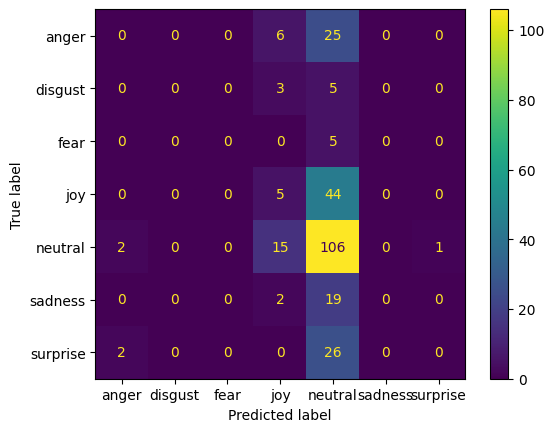

In [15]:
import numpy as np
import pandas as pd
import os
from src.conversation_processing import ConversationProcessor_CNN
import torch
import pickle
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
from datetime import datetime
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Limit to 50% of the total available memory on the GPU
torch.cuda.set_per_process_memory_fraction(0.8, device=0)

WANDB_RUN_NAME = f"TEST_EVALUATION_cnn-best-model-{datetime.now().strftime('%Y%m%d-%H%M%S')}"

################ Folders / Files ################
project_dir                 = os.getcwd()
MELD_folder                 = "test"
audio_data_folder           = "dont_care"
text_data_csv_filename      = "dont_care.csv"
combined_audio_data_folder  = "dont_care"
combined_csv_filename       = "dont_care.csv"
embeddings_plk_filename     = "final_tensor_conversation_v2_test"

myProcessor = ConversationProcessor_CNN(
    project_dir=project_dir,
    MELD_folder=MELD_folder,
    audio_data_folder=audio_data_folder,
    text_data_csv_filename=text_data_csv_filename,
    combined_audio_data_folder=combined_audio_data_folder,
    combined_csv_filename=combined_csv_filename,
    embeddings_plk_filename=embeddings_plk_filename)

with open(myProcessor.CODE_FILENAME, 'rb') as f:
    test_dataset_tensor = pickle.load(f)

test_dataset_targets = pd.read_csv(myProcessor.CODE_LABEL_FILENAME)

print(f"Dataset Tensor and CSV loaded from {myProcessor.CODE_FILENAME} and {myProcessor.CODE_LABEL_FILENAME}.")

################ Data loader ################
batch_size = 32

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(test_dataset_targets['Last_Emotion'].values)

labels = torch.tensor(labels_encoded, dtype=torch.long)
test_dataset = TensorDataset(test_dataset_tensor, labels)

test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=1, pin_memory=False, shuffle=False)

print(f"Data loader created with {len(test_loader.dataset)} samples.")


################ Model ################
model_path = os.path.join(myProcessor.BASE_DIR, 'cnn_best_model.pth')
activation_function = 'relu' # Need right type here

loaded_model = CNNClassifier(activation_function=activation_function) # Need right type here
loaded_model.to(device)
loaded_model.load_state_dict(torch.load(model_path, weights_only=True))
loaded_model.eval()
print("Model loaded.")


############# EVALUATE ################
val_total = 0
val_correct = 0
all_test_preds = []
all_test_labels = []

for batch_x, batch_y in test_loader:
    batch_x, batch_y = batch_x.to(device), batch_y.to(device)

    outputs = loaded_model(batch_x)
    _, predicted = torch.max(outputs, 1)
    val_total += batch_y.size(0)
    val_correct += (predicted == batch_y).sum().item()

    # Collect for F1
    all_test_preds.extend(predicted.cpu().numpy())
    all_test_labels.extend(batch_y.cpu().numpy())

weighted_f1 = f1_score(all_test_labels, all_test_preds, average='weighted')
macro_f1 = f1_score(all_test_labels, all_test_preds, average='macro')
accuracy = val_correct / val_total

print(f"accuracy: {accuracy * 100:.2f}%")
print(f"weighted_f1: {weighted_f1:.2f}%")
print(f"macro_f1: {macro_f1:.2f}%")


print(f"TEST classes string:{label_encoder.classes_}")
run = wandb.init(
    entity=entity,
    project=project,
    name=WANDB_RUN_NAME,
)



wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                        y_true=all_test_labels, preds=all_test_preds,
                        class_names=label_encoder.classes_)})

wandb.finish()



cm = confusion_matrix(all_test_labels, all_test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=label_encoder.classes_)

disp.plot()

plt.show()
